## Odstraňovanie dát

In [1]:
# dependencies
import pandas as pd
import os.path as path
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
import pickle
from sortedcontainers import SortedList
import time
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# local modules
import sys
sys.path.append("..")
from _ import constants

In [3]:
# load data
df_train = pd.read_csv(constants.TRAIN,sep=",")

### Atribút user_id

#### Počet používateľov, ktorí majú len jednu akciu

Odstránim používateľov, ktorí majú jednu akciu - čo implicitne znamená aj jednu session. Takíto používatelia sú nevhodní na učenie.

In [4]:
user_id_count = df_train.user_id.value_counts().reset_index(name="count").rename(columns={'index': 'user_id'})

In [5]:
len(df_train[df_train['user_id'].isin(user_id_count[(user_id_count['count'] == 1)]['user_id'])])

142994

In [6]:
df_train = df_train[~df_train['user_id'].isin(user_id_count[(user_id_count['count'] == 1)]['user_id'])]

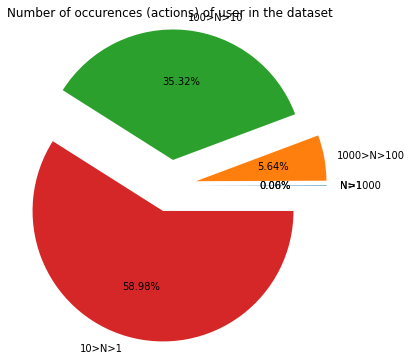

In [7]:
user_id_count = df_train.user_id.value_counts().reset_index(name="count").rename(columns={'index': 'user_id'})
user_id_groups = pd.DataFrame({
    'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        user_id_count[user_id_count['count'] > 1000].count()[0],
        user_id_count[(user_id_count['count'] > 100) & (user_id_count['count'] < 1000)].count()[0],
        user_id_count[(user_id_count['count'] > 10) & (user_id_count['count'] < 100)].count()[0],
        user_id_count[(user_id_count['count'] > 1) & (user_id_count['count'] < 10)].count()[0],
        user_id_count[user_id_count['count'] == 1].count()[0]
    ]
});

pi,ax = plt.subplots(figsize=[10,6]);
plt.title("Number of occurences (actions) of user in the dataset")
plt.pie(x=user_id_groups['count'], labels=user_id_groups['type'], explode=[0.2]*5, autopct="%.2f%%");

In [8]:
len(df_train.user_id)

15789998

### Atribút session

In [9]:
session_action_count = df_train.groupby(['session_id'])['action_type'].count().reset_index(name="count")

#### Odstránenie single-step sessions a excesívnych sessions

V prvom kroku sme síce odstránili používateľov, ktorí majú jednu session a zároveň jednu akciu, avšak my sme neodstránili sessions používateľov, ktoré majú jeden jediný krok v niektorej zo svojich sessions.

Takisto by sme mohli vyhodiť tie sessions, ktoré sú nad 100 krokov.

Vidíme, že tu su už dáta pomerne pekne distribuované. Na grafe môžme vidieť, že necelá polovica sessions má od 1-10 akcií. Vyše štvrtina je v rozpätií 10-100. Necelá štvrtina sú single-step sessions. 

In [10]:
df_train = df_train[~df_train['session_id'].isin(session_action_count[(session_action_count['count'] == 1) | (session_action_count['count'] > 100)]['session_id'])]

In [11]:
session_action_count = df_train.groupby(['session_id'])['action_type'].count().reset_index(name="count")

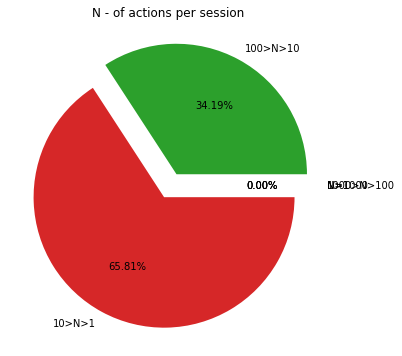

In [12]:
session_action_count_groups = pd.DataFrame({
   'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        session_action_count[session_action_count['count'] > 1000].count()[0],
        session_action_count[(session_action_count['count'] > 100) & (session_action_count['count'] < 1000)].count()[0],
        session_action_count[(session_action_count['count'] > 10) & (session_action_count['count'] < 100)].count()[0],
        session_action_count[(session_action_count['count'] > 1) & (session_action_count['count'] < 10)].count()[0],
        session_action_count[session_action_count['count'] == 1].count()[0]
    ]
});

pi,ax = plt.subplots(figsize=[10,6]);

plt.pie(x=session_action_count_groups['count'], labels=session_action_count_groups['type'], explode=[0.1]*5, autopct="%.2f%%")
plt.title('N - of actions per session ')
plt.show()

In [13]:
len(df_train)

9379652

#### Odstránienie duplikovaných párov session_id - step

In [14]:
df_train = df_train.reset_index().drop_duplicates(subset=['session_id','step'],keep='last').set_index('index')

### Uloženie do súboru

In [15]:
df_train.to_parquet(constants.TRAIN_DROPPED, index=False)